In [668]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.options.display.max_columns = 15
pd.options.display.max_rows = 20
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,8)
# plt.style.use('dark_background')

# Analysis of Real Estate Data and Covid in the Manhattan area

In [669]:
# We first import the data
rent_df = pd.read_csv("data/real_estate/fresh_rent_data.csv", parse_dates=True)
rent_df = rent_df.replace('None', np.nan)

rent_df['date'] = pd.to_datetime(rent_df['date'])
rent_df = rent_df.astype({
    'area': np.float64,
    'beds': np.float64,
    'baths': np.float64,
})
rent_df = rent_df.rename({"BOROUGH": "borough"}, axis=1)
rent_df = rent_df.drop(['zillow_id', 'living_area', 'lot_area', 'beds', 'baths', 'status_type', 'zip_code'], axis=1)

The structure of the data is:

In [670]:
rent_df

,date,event_description,price,address_city,area,home_type,borough
0,2021-04-16,Listed for rent,1500,Maspeth,NaN,APARTMENT,queens
1,2021-03-03,Price change,1300,Maspeth,350.0,APARTMENT,queens
2,2021-02-17,Listed for rent,1350,Maspeth,350.0,APARTMENT,queens
3,2021-04-10,Listed for rent,3000,Maspeth,NaN,MULTI_FAMILY,queens
4,2021-03-23,Listed for rent,3200,Flushing,3000.0,SINGLE_FAMILY,queens
...,...,...,...,...,...,...,...
48316,2021-03-13,No price history,2500,Bayside,1100.0,APARTMENT,queens
48317,2021-03-12,No price history,2400,Bayside,NaN,APARTMENT,queens
48318,2021-02-01,No price history,2299,Bayside,1000.0,MULTI_FAMILY,queens
48319,2021-01-04,No price history,2274,Bayside,NaN,MULTI_FAMILY,queens


We divide the data into boroughs to analyze them individually

In [671]:
rent_ny = {
    'queens': rent_df[rent_df['borough'] == 'queens'],
    'bronx': rent_df[rent_df['borough'] == 'bronx'],
    'brooklyn': rent_df[rent_df['borough'] == 'brooklyn'],
    'staten': rent_df[rent_df['borough'] == 'staten_island'],
    'manhattan': rent_df[rent_df['borough'] == 'manhattan'],
}

Our analysis for real estate data starts from 06/01/2019 so we need to remove the properties with a date
before 06/01/2019


# Time Series Analysis on Manhattan

In [672]:
current_borough = 'manhattan'
rent_df = rent_ny[current_borough]
print(rent_df['price'].describe())

count    21466.000000
mean      3449.305041
std       2091.902089
min        500.000000
25%       2075.000000
50%       2700.000000
75%       3995.000000
max      15000.000000
Name: price, dtype: float64


Remove outliers from the data

In [673]:
rent_df.drop(rent_df[rent_df['price'] > 7_000].index, inplace=True)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [674]:
# Create a time series for average price, median price, and count  from the manhattan dataframe
rent_ts = rent_df.groupby(rent_df.date)['price'].agg(['mean','count', 'median'])
start = datetime.datetime(2019, 6, 1)
end = datetime.datetime(2021, 4, 1)
idx = pd.date_range(start, end)
rent_ts = rent_ts[(rent_ts.index >= start) & (rent_ts.index <= end)]
rent_ts = rent_ts.reindex(idx)
rent_ts = rent_ts.rename({
    'mean': 'mean_price',
    'count': 'rent_count',
    'median': 'median_price'
}, axis=1)
rent_ts

,mean_price,rent_count,median_price
2019-06-01,3200.000000,1.0,3200.0
2019-06-02,NaN,NaN,NaN
2019-06-03,4247.500000,2.0,4247.5
2019-06-04,2800.000000,1.0,2800.0
2019-06-05,3721.000000,3.0,2850.0
...,...,...,...
2021-03-28,2895.207048,227.0,2500.0
2021-03-29,2885.548822,297.0,2500.0
2021-03-30,2941.651297,347.0,2600.0
2021-03-31,2841.966245,237.0,2500.0


Raw time series for Manhattan

<AxesSubplot:>

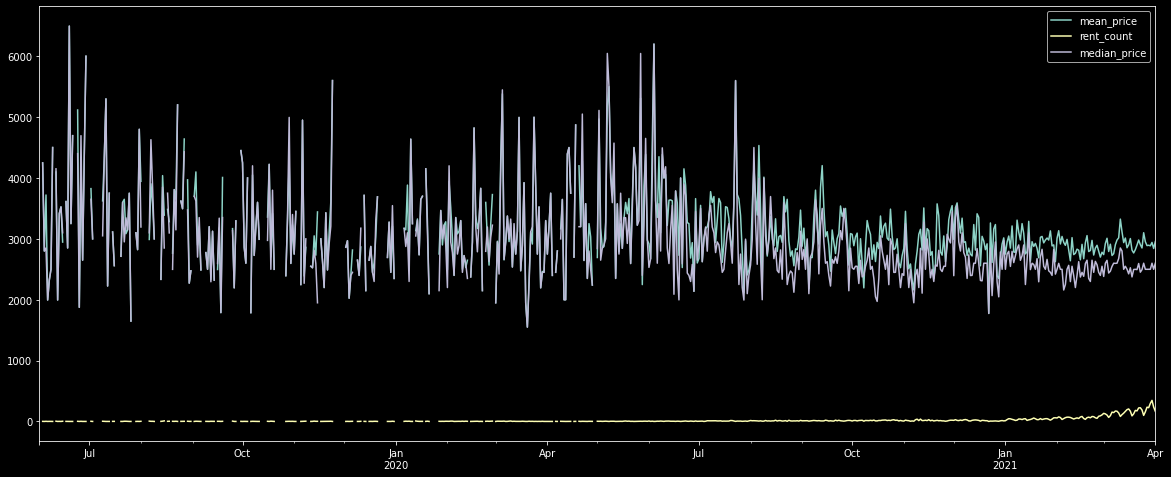

In [675]:
rent_ts.plot()


We need to fill in missing values. We use interpolation to do so

In [676]:
rent_ts = rent_ts.interpolate(method='spline', order=2)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:279: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


<AxesSubplot:>

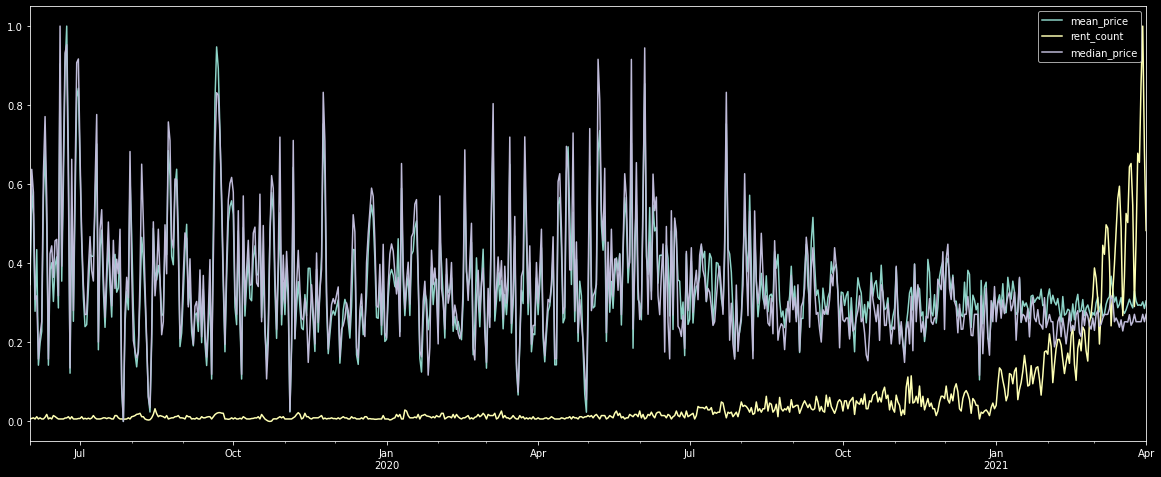

In [677]:
scaler = MinMaxScaler()
rent_ts = pd.DataFrame(scaler.fit_transform(rent_ts), index=rent_ts.index, columns=rent_ts.columns)
rent_ts.plot()

Now we need to smooth the data using a rolling window of 5 days and scale the data using min-max scaling.

We might need to use a trailing window because we are trying to forecast into the future.

Comparison between different smoothing options:

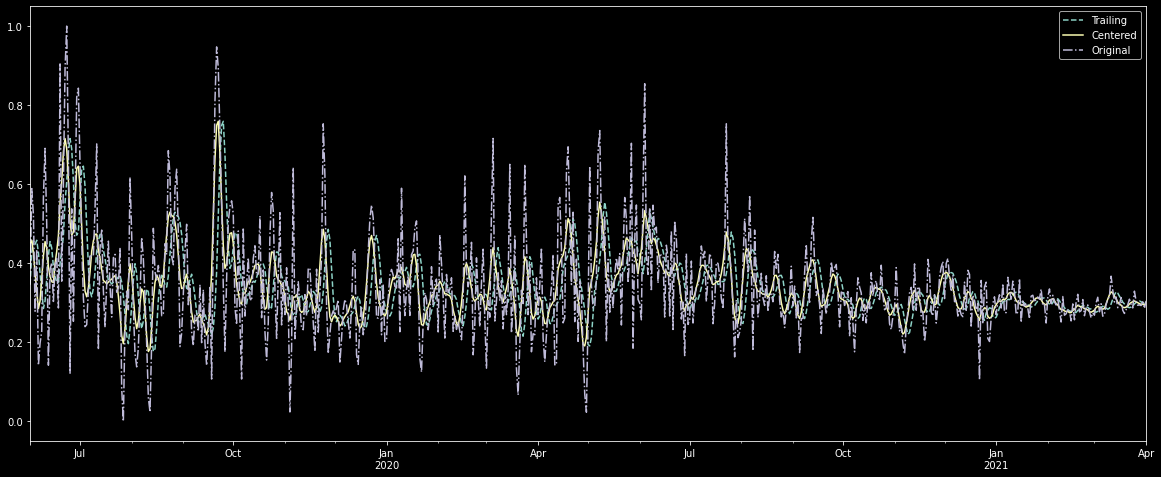

In [678]:
fig, ax = plt.subplots()
smoothed_ts = rent_ts['mean_price'].rolling(7, win_type='triang', min_periods=1).mean()
smoothed_ts.plot(style='--', legend=True, ax=ax)
smoothed_ts_centered = rent_ts['mean_price'].rolling(7, win_type='triang', min_periods=1, center=True).mean()
smoothed_ts_centered.plot(legend=True, ax=ax)
smoothed_ts_not_smoothed = rent_ts['mean_price']
smoothed_ts_not_smoothed.plot(style='-.', legend=True, ax=ax)
ax.legend(["Trailing", "Centered", "Original"])


We also explore the price/sqr_feet

In [679]:
# we take the properties that actually have the area listed
price_sqft = rent_df[ ~rent_df['area'].isna() ].sort_values('date')
price_sqft['price_per_sqft'] = price_sqft['price']/price_sqft['area']

price_sqft = price_sqft.groupby(price_sqft.date)['price_per_sqft'].agg(['mean', 'median'])
price_sqft = price_sqft.rename({
    'mean': 'mean_price_per_sqft',
    'median': 'median_price_per_sqft'
}, axis=1)
price_sqft = price_sqft.reindex(idx)
price_sqft = price_sqft.interpolate(method='spline', order=2)
price_sqft = pd.DataFrame(scaler.fit_transform(price_sqft), index=price_sqft.index, columns=price_sqft.columns)
# price_sqft = price_sqft.rolling(7, win_type='triang', min_periods=1).mean()
rent_ts = pd.concat([rent_ts, price_sqft], axis=1)
rent_ts

,mean_price,rent_count,median_price,mean_price_per_sqft,median_price_per_sqft
2019-06-01,0.346340,0.006219,0.383278,NaN,NaN
2019-06-02,0.589026,0.007559,0.637620,NaN,NaN
2019-06-03,0.523715,0.009091,0.579338,0.371368,0.371368
2019-06-04,0.278608,0.006219,0.308411,0.400047,0.410469
2019-06-05,0.434562,0.011963,0.317769,0.410451,0.418975
...,...,...,...,...,...
2021-03-28,0.294729,0.655336,0.252260,0.375550,0.349379
2021-03-29,0.293094,0.856390,0.252260,0.359170,0.341482
2021-03-30,0.302594,1.000000,0.270977,0.357571,0.354614
2021-03-31,0.285714,0.684058,0.252260,0.360774,0.367309


# Introducing COVID data

In [680]:
nyc_covid_df = pd.read_csv("data/covid/covid_nyc.csv")
nyc_covid_df.set_index("date", drop=True)
nyc_covid_df.drop(['city_pop2019', 'cityname', 'statename', 'statefips'], axis=1, inplace=True)
nyc_covid_df['date'] = pd.to_datetime(nyc_covid_df['date'])
nyc_covid_df = nyc_covid_df[(nyc_covid_df['date'] >= start) & (nyc_covid_df['date'] <= end)]
nyc_covid_ts = nyc_covid_df.set_index('date', drop=True)
nyc_covid_ts = nyc_covid_ts.rename({col: col + "_covid" for col in nyc_covid_ts.columns}, axis=1)

FileNotFoundError: [Errno 2] No such file or directory: 'data/covid/covid_county.csv'

Covid raw data:

In [ ]:
nyc_covid_ts = pd.DataFrame(scaler.fit_transform(nyc_covid_ts), columns=nyc_covid_ts.columns, index=nyc_covid_ts.index)
nyc_covid_ts.plot()


In [ ]:
ts = pd.concat([rent_ts, nyc_covid_ts], axis=1)

In [ ]:
ts

In [ ]:
ts[['case_rate_covid', 'new_case_rate_covid', 'mean_price', 'mean_price_per_sqft']].plot()

# Seasonal Decompositions
Decomposition is the process of understanding generalizations and problems related to time-series forecasting.
We can leverage seasonal decomposition to remove seasonality from data and check the data only with the trend,
cyclic, and irregular variations.

First we explore the decompositions of COVID time series

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

residuals = dict()


legend = []
for col in ts.columns:
    if 'covid' in col:
        legend.append(col)
        covid_df = ts[col]
        covid_decomposition = seasonal_decompose(covid_df.drop(covid_df[covid_df.isna()].index), model='additive')
        residuals[col+'_resid'] = covid_decomposition.resid
        covid_decomposition.plot()

residuals_ts = pd.concat(residuals, axis=1)

In [ ]:
price = ts['mean_price']
price_decomposition = seasonal_decompose(price.drop(price[price.isna()].index), model='additive')
price_decomposition.plot()
plt.show()

In [ ]:
ts = pd.concat([ts, residuals_ts, price_decomposition.resid.rename({'resid': 'mean_price_resid' }, axis=1)], axis=1)

In [ ]:
ts.plot()

# Autocorrelation plots
Autocorrelation is used to check randomness in data. It helps to identify types of data where the period is not known.

https://stats.stackexchange.com/questions/357300/what-does-pandas-autocorrelation-graph-show]

# covid case rate autocorrelation plot:

Ploting the PACF and ACF of case rate

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

case_rate = ts[~ts['case_rate_covid'].isna()]['case_rate_covid']
autocorrelation_plot(case_rate.tolist())
plot_acf(case_rate)
plot_pacf(case_rate)

new_case_rate = ts[~ts['new_case_rate_covid'].isna()]['new_case_rate_covid']
autocorrelation_plot(new_case_rate.tolist())
plot_acf(new_case_rate)
plot_pacf(new_case_rate)

Ploting the PACF and ACF of mean price and number of properties for rent

In [ ]:
count = ts[~ts['rent_count'].isna()]['rent_count']
autocorrelation_plot(count)
plot_acf(count)
plot_pacf(count)

In [ ]:
mean_price = ts[~ts['mean_price'].isna()]['mean_price']
autocorrelation_plot(mean_price)
plot_acf(mean_price)
plot_pacf(mean_price)

# Cross Correlation

The first plot shows the correlation with a forward lag

In [ ]:
# correlation using just ccf and then plotting with custom function
from math import sqrt
from statsmodels.tsa.stattools import ccf

y = new_case_rate
x = mean_price[(ts.index >= y.index.min()) & (mean_price.index <= y.index.max())]

cross_correlation = ccf(x, y, adjusted=False)
plt.stem(cross_correlation)
ci = 2*(1/sqrt(len(x)))
plt.plot([i for i in range(len(cross_correlation))], [ci]*len(cross_correlation), color='r', ls="--")
plt.plot([i for i in range(len(cross_correlation))], [-1*ci]*len(cross_correlation), color='r', ls="--")
plt.show()

Now we show the correlation with forward and backwards lag

In [ ]:
def ccorr_plot(x, y, values=20):
    # this function plots the cross correlation plot with positive and negative lags
    backwards = ccf(x[::-1], y[::-1], adjusted=False)[::-1][(-1*(values+1)):]
    forwards = ccf(x,y, adjusted=False)[:(values+1)]
    ccf_output = np.r_[backwards[:-1], forwards]  # we need the [:-1] because we have a duplicate for lag=0
    x_axis = list(range(-1*values, values+1))
    ci = 2*(1/sqrt(len(x)))
    plt.plot(x_axis, [ci]*len(x_axis), color='r', ls="--")
    plt.plot(x_axis, [-1*ci]*len(x_axis), color='r', ls="--")
    plt.stem(x_axis, ccf_output)
    plt.show()

ccorr_plot(x, y, 100)

# Time Series with lag

A negative value for h (lag) is a correlation between the x-variable at a time before t (the current time) and the y-variable at time t.
if h = -2 then the ccf value would give the correlation between x<sub>t-2</sub> and y<sub>t</sub>.

* if x<sub>t+h</sub> with h __negative__, is a predictor of y<sub>t</sub>, it is said that x __leads__ y.
* if x<sub>t+h</sub> with h __positive__, is a predictor of y<sub>t</sub>, it is said that x __lags__ y.

In some problems, the goal may be to identify which variable is leading and which is lagging.
In many problems we consider, though, we’ll examine the x-variable(s) to be a leading variable
of the y-variable because we will want to use values of the x-variable to predict future values of y.

I think in this case because our x is real estate and our y is covid and h is negative we can say that real estate leads covid in some weird way.
This is not what we wanted to show but it is the result we are getting.

In [ ]:
# x = pd.DataFrame(scaler.fit_transform(np.array(x.tolist()).reshape(-1, 1)), index=x.index)
# y  = pd.DataFrame(scaler.fit_transform(np.array(y.tolist()).reshape(-1, 1)), index=y.index)
df = pd.concat([x.shift(75), y], axis=1)
df.plot()

In [ ]:
ts.corr()

In [ ]:
import seaborn as sns
corr = ts.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True,annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
# TODO: remove seasonality and apply diff


I think there is no seasonality in the real estate data but there seems to be seasons in the case-rate of covid 
but I need to do more research on this.

# Stationary Behavior
Stationary data means that the statistical properties of the particular process (mean and variance) do not vary with time.
Most TS models work on the assumption that the TS is stationary.

To test for stationarity we can use the Dickey-Fuller test. In this test the null hypothesis is that the Time series is non-stationary.
The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.
If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that
the series is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller_test(df):
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
print("COVID Results of Dicke-Fuller Test:")
dickey_fuller_test(case_rate)

It seems that we can't reject the null hypothesis in the case of COVID case-rate

In [ ]:
print("Rent Results of Dicke-Fuller Test:")
dickey_fuller_test(mean_price)

In the case of mean rent prices it seems that we can reject the null hypothesis and say that the time series is stationary

## Making COVID TS stationary
I think we can use the results from the decomposition that we got earlier and get the residual

In [ ]:
test = ts['case_rate_covid_resid'][~ts['case_rate_covid_resid'].isna()]

In [ ]:
test.plot()
dickey_fuller_test(test)
# result_covid.plot()#%%

In [ ]:
x = ts['resid'][(ts['resid'].index >= y.index.min()) & (ts['resid'].index <= y.index.max())].dropna()
x

In [ ]:
df = pd.concat([x, test], axis=1)
df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
df.plot()

In [ ]:
df

In [ ]:
ccorr_plot(df['resid'].dropna(), df['case_rate_covid_resid'].dropna(), 100)

In [ ]:
df.corr()

Granger causality analysis rests on the assumption that if a variable X causes Y then changes in X will systematically occur 
before changes in Y. We will thus find that the lagged values of X will exhibit a statistically significant correlation with Y. 
Correlation however does not prove causation.

# Model Evaluation

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

# model = ARIMA(df['resid'], order=(3,0, 2))

In [ ]:
model = pm.auto_arima(df['resid'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

In [ ]:
results_AR = model.fit(df['resid'], disp=1)
df.plot()
# plt.plot(results_AR.predict(), color='red')
# results_AR.plot_predict()
plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

data = ts[['mean_price', 'median_price_per_sqft', 'new_case_rate_covid']]
data.fillna(data.min(), inplace=True)

In [ ]:
df = data
# import for Granger's Causality Test

granger_test = sm.tsa.stattools.grangercausalitytests(df[['mean_price', 'median_price_per_sqft']], maxlag=2, verbose=True)
granger_test

In [ ]:
granger_test = sm.tsa.stattools.grangercausalitytests(df[['mean_price', 'new_case_rate_covid']], maxlag=2, verbose=True)
granger_test

In [ ]:
model = VAR(data)
model_fit = model.fit()

In [ ]:
pred = model_fit.forecast(model_fit.y, steps=1)
print(pred)
